# Dataset Summary: News Article Classification
The dataset consists of 4,000 news articles, each categorized into one of four topics: World, Sports, Business, and Sci/Tech. It has two columns: Article, containing the text of the news piece, and Category, a numerical label (0–3) representing its classification. The dataset is structured for text classification tasks, making it useful for machine learning models that analyze and categorize news content based on textual patterns. The categories are mapped as follows:

World -> 0

Sports -> 1

Business -> 2

Sci/Tech -> 3

The task is to analyze the text using transformers in news articles and build a model for categorizing them. The goal is to optimize the categorization process, and observe models' performermance using transformer interpreters. It can be used in E-news platfoms to aggregate news and categorize them efficiently.

## **Installing and Importing Necessary Libraries and Dependencies**

In [113]:
# installing the libraries for transformers
!pip install -U -q sentence-transformers transformers bitsandbytes accelerate sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/slayerCuda-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/slayerSNN-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/slayerLoihiCuda-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pi

In [114]:
!curl -O https://raw.githubusercontent.com/tanalam565/Article-Categorization/refs/heads/main/article_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100  940k  100  940k    0     0  2510k      0 --:--:-- --:--:-- --:--:-- 2515k


In [115]:
!pip install pandas numpy scikit-learn torch matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/slayerCuda-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/slayerSNN-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/slayerLoihiCuda-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pi

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_colwidth', None)

import torch
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,make_scorer,recall_score,precision_score,f1_score

import warnings
warnings.filterwarnings("ignore")

## **Loading the Dataset**

In [117]:
#Read the CSV file
data = pd.read_csv('article_data.csv')

## **Data Overview**

In [118]:
# Print first 5 rows of the data
data.head()

,Article,Category
0,"Sudan Govt rejects call to separate religion, state Sudanese rebel leaders #39; demand that Islam be kept out of government in the war-torn region of Darfur, has been rejected by government negotiators.",0
1,Hassan: #39;Abhorrent act #39; says Blair Western political leaders have united to condemn the kidnappers of charity worker Margaret Hassan after a video surfaced apparently showing a militant firing a pistol into the head of a blindfolded woman wearing an orange jumpsuit.,0
2,"Sharon Says Gaza Evacuation Set for 2005 (AP) AP - Israel's evacuation of the Gaza Strip will begin next summer and will take about 12 weeks, Prime Minister Ariel Sharon said Wednesday, reversing an earlier decision to speed up the pullout.",0
3,"Prince Charles chastised for quot;old fashioned quot; views A minister has launched a scathing attack on heir to the throne Prince Charles, accusing him of being quot;very old fashioned quot; and out of touch in his views on teaching in schools.",0
4,"U.S. Says N.Korea Blast Probably Not Nuclear SEOUL (Reuters) - A huge explosion rocked North Korea last week but U.S. and South Korean officials said on Sunday it was unlikely to have been a nuclear weapons test despite the appearance of a ""peculiar cloud"" over the area.",0


In [119]:
# Shape of the data
data.shape

(4000, 2)

In [120]:
## Check the value counts in Category column
data["Category"].value_counts()

Category
0    1000
1    1000
2    1000
3    1000
Name: count, dtype: int64

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Article   4000 non-null   object
 1   Category  4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


## **Exploratory Data Analysis (EDA)**


In [122]:
 # function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )

    plt.show()  

#### Distribution of category

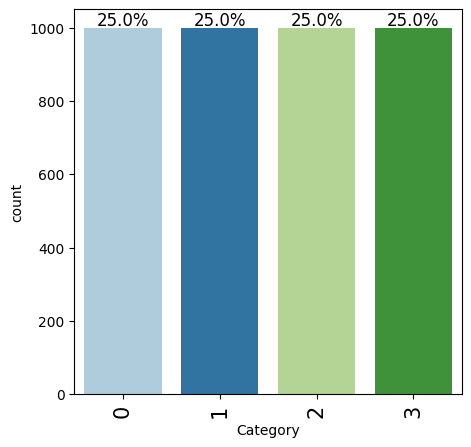

In [123]:
labeled_barplot(data, "Category", perc=True)

## **Model Building - Sentence Transformer**

#### Model Summary
The SentenceTransformer 'all-MiniLM-L6-v2 is a lightweight embedding model based on Microsoft's MiniLM architecture. It is designed to generate high-quality, dense vector representations of sentences, making it highly efficient for semantic similarity, clustering, retrieval, and classification tasks. With 6 transformer layers and 384 embedding dimensions, it balances performance and speed, achieving competitive accuracy while being computationally efficient. 

The predict_similarity function classifies a query by comparing its semantic embedding to a set of reference embeddings using cosine similarity. It identifies the most similar reference embedding by selecting the highest similarity score and retrieves the corresponding label from reference_labels.

In [124]:
#Defining the SentenceTransformer Model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [125]:
# A function for confusion matrix
def confusion_matrix_sklearn(model, predictors, target):
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Encoding the data

In [126]:
# setting the compute device
device = "cuda" if torch.cuda.is_available() else "cpu"

## Encoding the dataset.
embedding_matrix = model.encode(data["Article"],show_progress_bar=True,device=device)

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

### Train-Test Split

In [127]:
# Split the data
X = embedding_matrix
y = data["Category"]

In [128]:
# Initial split into training (80%) and testing (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42)

# Further split the temporary set into validation (10%) and test (10%) sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [129]:
print("Shape of the set of input variables for training:", X_train.shape)
print("Shape of the set of input variables for validation:", X_valid.shape)
print("Shape of the set of input variables for testing:", X_test.shape)

Shape of the set of input variables for training: (3200, 384)
Shape of the set of input variables for validation: (400, 384)
Shape of the set of input variables for testing: (400, 384)


In [130]:
print("Shape of the set of output variables for training:", y_train.shape)
print("Shape of the set of output variables for validation:", y_valid.shape)
print("Shape of the set of output variables for testing:", y_test.shape)

Shape of the set of output variables for training: (3200,)
Shape of the set of output variables for validation: (400,)
Shape of the set of output variables for testing: (400,)


In [131]:
# Prediction via similarity
def predict_similarity(query_embedding, reference_embeddings, reference_labels):
    similarities = cosine_similarity([query_embedding], reference_embeddings)
    # Get the index of the most similar embedding
    most_similar_index = np.argmax(similarities)
    most_similar_index = min(most_similar_index, len(reference_labels) - 1)
    # Get the label corresponding to the most similar embedding
    predicted_label = reference_labels.iloc[most_similar_index]
    return predicted_label

# Generate predictions
y_pred = np.array([predict_similarity(x, X_train, y_train) for x in X_test])

In [132]:
# First Evaluate on Validation Set
val_pred = np.array([predict_similarity(x, X_train, y_train) for x in X_valid])
print("Validation Accuracy:", np.mean(val_pred == y_valid))
print(classification_report(y_valid, val_pred))

# Final Test on Test Set
test_pred = np.array([predict_similarity(x, X_train, y_train) for x in X_test])
print("\nTest Accuracy:", np.mean(test_pred == y_test))
print(classification_report(y_test, test_pred))

Validation Accuracy: 0.8325
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        97
           1       0.93      0.96      0.94       112
           2       0.76      0.82      0.79       104
           3       0.79      0.69      0.74        87

    accuracy                           0.83       400
   macro avg       0.83      0.82      0.83       400
weighted avg       0.83      0.83      0.83       400


Test Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.92      0.88      0.89       112
           1       0.93      0.94      0.94       101
           2       0.73      0.82      0.77        90
           3       0.82      0.75      0.78        97

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



Accuracy: 0.85


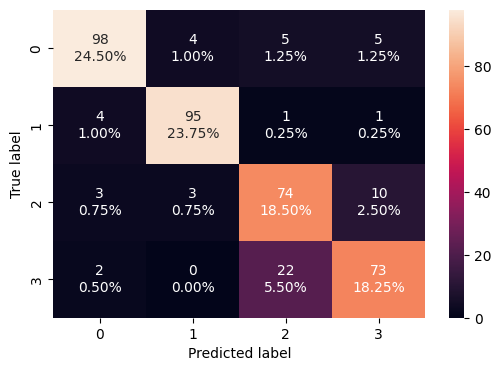

In [133]:
# Confusion matrix function
def confusion_matrix_sklearn(target, y_pred):
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [["{0:0.0f}".format(item) + "\n{0:.2%}".format(item/cm.flatten().sum())]
         for item in cm.flatten()]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# Evaluate
print("Accuracy:", np.mean(y_pred == y_test))
confusion_matrix_sklearn(y_test, y_pred)

In [134]:
# Convert to numpy arrays
y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)
all_indices = np.arange(len(y_test))

# Initialize storage
fp_indices_per_class = {}
fn_indices_per_class = {}

# Analyze each class
for target_class in sorted(np.unique(y_test)):
    # False Positives
    fp_mask = (y_pred_array == target_class) & (y_test_array != target_class)
    fp_indices = all_indices[fp_mask]

    # False Negatives
    fn_mask = (y_test_array == target_class) & (y_pred_array != target_class)
    fn_indices = all_indices[fn_mask]

    fp_indices_per_class[target_class] = fp_indices
    fn_indices_per_class[target_class] = fn_indices

    print(f"\nClass {target_class} Analysis:")
    print(f"False Positives (Predicted as {target_class} but wrong): {len(fp_indices)} cases")
    print(f"False Negatives (Missed true {target_class}): {len(fn_indices)} cases")
    if len(fp_indices) > 0:
        print(f"Example FP index: {fp_indices[0]}")
    if len(fn_indices) > 0:
        print(f"Example FN index: {fn_indices[0]}")


Class 0 Analysis:
False Positives (Predicted as 0 but wrong): 9 cases
False Negatives (Missed true 0): 14 cases
Example FP index: 18
Example FN index: 60

Class 1 Analysis:
False Positives (Predicted as 1 but wrong): 7 cases
False Negatives (Missed true 1): 6 cases
Example FP index: 5
Example FN index: 209

Class 2 Analysis:
False Positives (Predicted as 2 but wrong): 28 cases
False Negatives (Missed true 2): 16 cases
Example FP index: 6
Example FN index: 5

Class 3 Analysis:
False Positives (Predicted as 3 but wrong): 16 cases
False Negatives (Missed true 3): 24 cases
Example FP index: 15
Example FN index: 6


In [135]:
!pip install transformers-interpret

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/slayerCuda-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/slayerSNN-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/slayerLoihiCuda-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pi

In [136]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# Initialize explainer
from transformers_interpret import SequenceClassificationExplainer
explainer = SequenceClassificationExplainer(model, tokenizer)

# Analyze errors
error_text = data.iloc[fp_indices_per_class[0][0]]["Article"]
attributions = explainer(error_text)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [137]:
# numeric categories to actual names
label_map = {0:"World",1:"Sports",2:"Business",3:"Sci/Tech"}

# visualization function
def visualize_attributions(explainer, text, true_label, pred_label):
    attributions = explainer(text)

    print(f"\nTrue Category: {label_map[true_label]}")
    print(f"Predicted: {label_map[pred_label]} (confidence: {explainer.pred_probs.max():.2f})")
    print("\nTop Influential Words:")

    # Get top 5 positive/negative contributing words
    word_attributions = sorted(explainer.word_attributions,
                             key=lambda x: x[1],
                             reverse=True)

    for word, score in word_attributions[:10]:
        print(f"{word}: {score:.2f}")

    explainer.visualize()

In [138]:
def explain_specific_index(index):

    # Verify valid index
    if index < 0 or index >= len(data):
        print(f"Error: Index must be between 0 and {len(data)-1}")
        return

    # Get prediction details
    true_label = y_test.iloc[index]
    pred_label = y_pred[index]
    text = data.iloc[index]["Article"]

    # Print header
    print(f"\n{'='*60}")
    print(f"Analysis for Index {index}:")
    print(f"TRUE: {label_map[true_label]} | PREDICTED: {label_map[pred_label]}")
    print(f"{'='*60}")

    # Show text preview
    print(f"\nText Preview:\n{text[:200]}...\n")

    # Generate and display explanation
    print("Model Explanation:")
    visualize_attributions(explainer, text, true_label, pred_label)

    # Additional debug info
    print("\nDebug Info:")
    print(f"- Is FP: {(pred_label != true_label) and (pred_label in fp_indices_per_class)}")
    print(f"- Is FN: {(pred_label != true_label) and (true_label in fn_indices_per_class)}")

In [139]:
# Explain the indices
explain_specific_index(18)
explain_specific_index(209)
explain_specific_index(15)


Analysis for Index 18:
TRUE: Business | PREDICTED: World

Text Preview:
Princess Diana Fountain to Close Again (AP) AP - It has been fenced in, clogged with leaves, overrun with visitors and even used as a dog bath. Now the Princess Diana memorial fountain is to close aga...

Model Explanation:

True Category: Business
Predicted: World (confidence: 0.26)

Top Influential Words:
fountain: 0.44
grass: 0.42
fountain: 0.35
dog: 0.32
fence: 0.19
overrun: 0.16
so: 0.14
surrounding: 0.12
##ing: 0.10
splash: 0.09



Debug Info:
- Is FP: True
- Is FN: True

Analysis for Index 209:
TRUE: Sports | PREDICTED: World

Text Preview:
US Plutonium Shipment Reaches France Working under tight security from helicopters and police, port crews unloaded US military plutonium from a British ship on Wednesday after its arrival in northwest...

Model Explanation:

True Category: Sports
Predicted: World (confidence: 0.26)

Top Influential Words:
france: 0.42
france: 0.35
crews: 0.23
us: 0.20
pluto: 0.15
nuclear: 0.15
northwest: 0.12
.: 0.12
pluto: 0.12
said: 0.12



Debug Info:
- Is FP: True
- Is FN: True

Analysis for Index 15:
TRUE: Business | PREDICTED: Sci/Tech

Text Preview:
Bush, Kerry Differ on Approach to North Korea  SEOUL (Reuters) - The determination of North Korea to  develop nuclear arms could harden after President Bush and his  rival, Senator John Kerry, clashed...

Model Explanation:

True Category: Business
Predicted: Sci/Tech (confidence: 0.26)

Top Influential Words:
six: 0.54
arms: 0.47
differ: 0.14
nuclear: 0.13
bush: 0.13
bush: 0.12
senator: 0.11
could: 0.08
talks: 0.07
john: 0.06



Debug Info:
- Is FP: True
- Is FN: True


### Model Performance Summary
The model demonstrates strong performance in news classification, achieving 83.25% accuracy on the validation set and 85% accuracy on the test set. It performs particularly well in classifying Sports (precision: 0.93, recall: 0.96) and World (precision: 0.92, recall: 0.88) articles, indicating high confidence and reliability in these categories. However, Business and Sci/Tech categories show lower recall, suggesting that some articles from these groups are being misclassified, particularly with Business being confused with World and Sci/Tech. 

The misclassifications observed at indices 15, 18, and 209 suggest that the model's errors occured from a lack of sufficient context or ambiguity in the articles. For instance, in index 18, the article about the closure of the Princess Diana Fountain was misclassified as 'World' instead of 'Business', even though it could fit both categories. Similarly, index 209 lacked enough context to distinguish between 'World' and 'Sports' news. In index 15, key terms like 'Kerry' and 'nuclear' heavily influenced the model's prediction, leading it to incorrectly classify the article as 'Sci/Tech' rather than 'Business'.

Additionally, it's noted that the word importance value changes every time the interpreter is run. This highlights that while each word plays a role in the model's predictions, the relative importance of each word can vary. This variability can provide insight into the multiple reasons or factors contributing to a misclassification. Overall, despite these challenges, the Sentence Transformer model performs well at categorizing news articles and demonstrates effective handling of most of the dataset.

## **Model Building - Transformer**

### Model Summary
The pretrained model in this context utilizes BERT (Bidirectional Encoder Representations from Transformers) for natural language processing tasks. BERT is a transformer-based model designed to understand the context of words in a sentence by considering both left and right surrounding words. It is highly effective for tasks like text classification, sentiment analysis, and question answering. The model is fine-tuned using the BertTokenizer for tokenizing input text, which is then processed through the BERT layers to generate contextual embeddings. These embeddings are utilized for downstream tasks with optimized training techniques like AdamW optimizer and learning rate scheduling for improved performance.

In [140]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW

In [141]:
# Preprocessing
texts = data.iloc[:, 0].tolist()
labels = data.iloc[:, 1].tolist()

In [142]:
# Label mapping
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

In [143]:
# A class to prepare the dataset for training
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

#### Named it enhanced and removed the old one. I kept the latest one to save training time while training multiple times.

In [144]:
class EnhancedTransformer(nn.Module):
    def __init__(self, vocab_size, num_classes, d_model=256, nhead=8, num_layers=3, dropout=0.3):
        super(EnhancedTransformer, self).__init__()

        # Embedding layer with more capacity
        self.embedding = nn.Embedding(vocab_size, d_model)

        # Positional encoding with more layers and heads
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            activation='gelu',
            batch_first=True  
        )
        self.pos_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.BatchNorm1d(d_model//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, d_model//4),
            nn.BatchNorm1d(d_model//4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//4, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        # Embedding
        x = self.embedding(input_ids)

        # Transformer Encoder 
        x = self.pos_encoder(x)

        # Global average pooling 
        mask = attention_mask.bool()
        x = x.masked_fill(~mask.unsqueeze(-1), 0)
        x = x.sum(dim=1) / (mask.sum(dim=1, keepdim=True) + 1e-8)

        # Classification
        logits = self.classifier(x)
        return logits

In [145]:
# Prepare the data set for training
def prepare_data(texts, labels, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels,
        test_size=test_size,
        random_state=random_state,
        stratify=labels
    )

    return X_train, X_test, y_train, y_test

In [146]:
# A function to train the model
def train_model(model, train_loader, val_loader, epochs=15):
    # Device selection
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare optimizer and schedule
    optimizer = AdamW(model.parameters(), lr=2.3e-4, weight_decay=0.01)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    # Loss function with class weights
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    model.to(device)

    # Training history
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Training phase
        for batch in train_loader:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()

        # Validation phase
        model.eval()
        total_val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct_predictions / total_predictions

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }


In [147]:
# A function for classification matrix
def generate_classification_metrics(model, val_loader, label_map):
    
    # Set model to evaluation mode
    model.eval()

    # Device handling
    device = next(model.parameters()).device

    # Lists to store true labels and predictions
    true_labels = []
    predicted_labels = []

    # Disable gradient computation
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Get model predictions
            outputs = model(input_ids, attention_mask)

            # Get the predicted class
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    # Generate classification report
    class_report = classification_report(
        true_labels,
        predicted_labels,
        target_names=list(label_map.values())
    )

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Visualize Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=list(label_map.values()),
        yticklabels=list(label_map.values())
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()

    return class_report, conf_matrix

In [148]:
# A function to track the misclassified indices
def track_misclassifications(model, val_loader, label_map, X_test):
    
    model.eval()

    # Device handling
    device = next(model.parameters()).device

    # Dictionary to store misclassification details
    misclassifications = {label: [] for label in label_map.values()}

    # Disable gradient computation
    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Get model predictions
            outputs = model(input_ids, attention_mask)

            # Get the predicted class
            _, preds = torch.max(outputs, 1)

            # Move tensors to CPU
            labels_cpu = labels.cpu().numpy()
            preds_cpu = preds.cpu().numpy()

            # Track misclassifications
            for i in range(len(labels_cpu)):
                # Calculate global index in X_test
                global_idx = idx * val_loader.batch_size + i

                # Check if prediction is incorrect
                if labels_cpu[i] != preds_cpu[i]:
                    true_label = label_map[labels_cpu[i]]
                    predicted_label = label_map[preds_cpu[i]]

                    misclassifications[true_label].append({
                        'text': X_test[global_idx],
                        'true_label': true_label,
                        'predicted_label': predicted_label,
                        'global_index': global_idx
                    })

    return misclassifications

def print_misclassification_summary(misclassifications):
    
    print("\n--- Misclassification Summary ---")
    for true_label, mislabeled_instances in misclassifications.items():
        print(f"\n{true_label} Label Misclassifications:")
        print(f"Total misclassified: {len(mislabeled_instances)}")

        # Print first few misclassified instances
        for i, instance in enumerate(mislabeled_instances[:5]):
            print(f"\nInstance {i+1}:")
            print(f"  True Label: {instance['true_label']}")
            print(f"  Predicted Label: {instance['predicted_label']}")
            print(f"  Global Index: {instance['global_index']}")
            print(f"  Text (truncated): {instance['text'][:200]}...")
            

In [149]:
# Main function to include misclassification tracking
def main():
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data(texts, labels)

    # Tokenization
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create datasets and dataloaders
    train_dataset = NewsDataset(X_train, y_train, tokenizer)
    val_dataset = NewsDataset(X_test, y_test, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Model initialization
    vocab_size = tokenizer.vocab_size
    num_classes = len(label_map)

    model = EnhancedTransformer(vocab_size, num_classes)

    # Training
    training_history = train_model(model, train_loader, val_loader)

    # Generate classification metrics
    print("\n--- Classification Metrics ---")
    classification_rep, conf_matrix = generate_classification_metrics(model, val_loader, label_map)

    print("Classification Report:")
    print(classification_rep)

    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Track misclassifications
    misclassifications = track_misclassifications(model, val_loader, label_map, X_test)

    # Print misclassification summary
    print_misclassification_summary(misclassifications)

    # Return necessary variables to make them accessible outside the function
    return model, tokenizer, training_history, misclassifications, val_loader, X_test


#### Transformer Interpreter Summary:
This is a Transformer model interpreter designed to explain the predictions of a pretrained transformer-based model in a text classification task. It primarily focuses on explaining misclassifications and providing word-level importance scores to help understand the model's decision-making process. The interpreter includes methods to:

Identify misclassified instances by comparing model predictions with true labels.

Compute word importance by masking individual words and measuring their impact on the model's prediction.

Provide detailed explanations by showing the model's predicted label, confidence, and a bar plot of word importances.

In [150]:
class TransformerExplainer:
    def __init__(self, model, tokenizer, val_loader, X_test, label_map, device=None):
        
        # Set default device
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.model = model.to(self.device).eval()

        # Store other parameters
        self.tokenizer = tokenizer
        self.val_loader = val_loader
        self.X_test = X_test
        self.label_map = label_map

        # Find misclassified indices
        self.misclassifications = self._get_misclassified_indices()
    
    # Get misclassified indices
    def _get_misclassified_indices(self):
        misclassified = set()
        global_idx = 0

        with torch.no_grad():
            for batch in self.val_loader:
                # Ensure tensor types
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Get predictions
                outputs = self.model(input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs, dim=1)

                # Track misclassifications
                misclassified.update(
                    global_idx + i
                    for i, (label, pred) in enumerate(zip(labels, preds))
                    if label != pred
                )
                global_idx += len(labels)

        return misclassified

    def _compute_word_importance(self, input_ids, attention_mask):
        
        # Get original prediction
        with torch.no_grad():
            original_output = self.model(input_ids, attention_mask=attention_mask)
            original_pred = torch.softmax(original_output, dim=1)

        # Compute word importance
        word_importances = []
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])

        for i in range(1, len(tokens)-1): 
            # Create a mask to zero out the current word
            masked_input_ids = input_ids.clone()
            masked_input_ids[0, i] = self.tokenizer.mask_token_id

            # Get prediction with word masked
            with torch.no_grad():
                masked_output = self.model(masked_input_ids, attention_mask=attention_mask)
                masked_pred = torch.softmax(masked_output, dim=1)

            # Compute the difference in prediction
            pred_diff = original_pred - masked_pred
            importance = torch.abs(pred_diff).mean().item()
            word_importances.append(importance)

        return dict(zip(tokens[1:-1], word_importances))

    def explain(self, index):
        # Get the text
        text = str(self.X_test[index])

        # Tokenize the input
        inputs = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=256
        )

        # Move inputs to device
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        # Get model predictions
        with torch.no_grad():
            outputs = self.model(input_ids, attention_mask=attention_mask)

            # Apply softmax to get probabilities
            probs = torch.softmax(outputs, dim=1)[0]

            # Get predicted label and probability
            predicted_label_idx = torch.argmax(probs).item()
            predicted_prob = probs[predicted_label_idx].item()

        # Check if misclassified
        is_misclassified = index in self.misclassifications

        # Compute word importances
        word_importances = self._compute_word_importance(input_ids, attention_mask)

        # Prepare detailed explanations
        explanations = {
            self.label_map[i]: prob.item()
            for i, prob in enumerate(probs)
        }

        # Visualize word importances
        plt.figure(figsize=(12, 5))
        words = list(word_importances.keys())
        importances = list(word_importances.values())

        sns.barplot(x=words, y=importances)
        plt.title(f"Word Importance for Prediction: {self.label_map[predicted_label_idx]}")
        plt.xlabel("Words")
        plt.ylabel("Importance Score")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        # Print explanation details
        print(f"\nIndex: {index}")
        print(f"Text: {text[:200]}{'...' if len(text) > 200 else ''}")
        print("\nDetailed Predictions:")
        for label, score in sorted(explanations.items(), key=lambda x: x[1], reverse=True):
            print(f"{label}: {score:.2%}")

        print(f"\nPredicted: {self.label_map[predicted_label_idx]}")
        print(f"Confidence: {predicted_prob:.2%}")
        print(f"Status: {'MISCLASSIFIED' if is_misclassified else 'Correct'}")

        # Show the plot
        plt.show()

        return is_misclassified, explanations, word_importances

In [151]:
# Run the main function
model, tokenizer, training_history, misclassifications, val_loader, X_test = main()

Using device: cuda
Epoch 1/15:
Train Loss: 1.4130
Validation Loss: 1.3522
Validation Accuracy: 42.25%
Epoch 2/15:
Train Loss: 1.0888
Validation Loss: 1.2859
Validation Accuracy: 51.25%
Epoch 3/15:
Train Loss: 0.7468
Validation Loss: 0.7162
Validation Accuracy: 72.62%
Epoch 4/15:
Train Loss: 0.5293
Validation Loss: 0.8056
Validation Accuracy: 70.88%
Epoch 5/15:
Train Loss: 0.3845
Validation Loss: 0.6974
Validation Accuracy: 74.75%
Epoch 6/15:
Train Loss: 0.2834
Validation Loss: 0.7275
Validation Accuracy: 75.25%
Epoch 7/15:
Train Loss: 0.2365
Validation Loss: 0.8569
Validation Accuracy: 73.38%
Epoch 8/15:
Train Loss: 0.1809
Validation Loss: 0.9363
Validation Accuracy: 73.88%
Epoch 9/15:
Train Loss: 0.1351
Validation Loss: 0.7921
Validation Accuracy: 77.00%
Epoch 10/15:
Train Loss: 0.1070
Validation Loss: 0.8059
Validation Accuracy: 76.12%
Epoch 11/15:
Train Loss: 0.0843
Validation Loss: 0.8827
Validation Accuracy: 77.00%
Epoch 12/15:
Train Loss: 0.0642
Validation Loss: 0.8825
Validation


Index: 15
Text: Expansion may lead to division The Asia-Europe Meeting, ASEM, will hold its fifth summit in Hanoi in October amidst a recent crisis over the inclusion of Myanmar.

Detailed Predictions:
Sci/Tech: 91.01%
Business: 5.78%
World: 1.68%
Sports: 1.52%

Predicted: Sci/Tech
Confidence: 91.01%
Status: MISCLASSIFIED


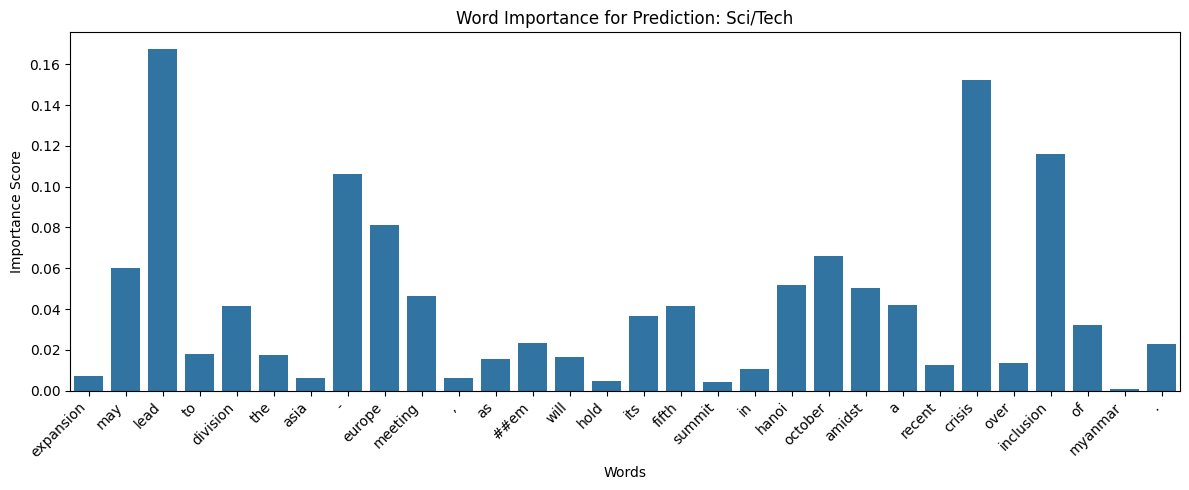

In [152]:
explainer = TransformerExplainer(
    model=model,
    tokenizer=tokenizer,
    val_loader=val_loader,
    X_test=X_test,
    label_map=label_map
)

# Explain a specific index
is_misclassified, explanations, word_importances = explainer.explain(index=15)


Index: 7
Text: Study raises stent doubts Heart patients aren #39;t more likely to live long term after getting the artery-opening tubes called stents, according to a study released yesterday by researchers at Duke U...

Detailed Predictions:
Sci/Tech: 98.66%
Business: 0.70%
World: 0.34%
Sports: 0.30%

Predicted: Sci/Tech
Confidence: 98.66%
Status: Correct


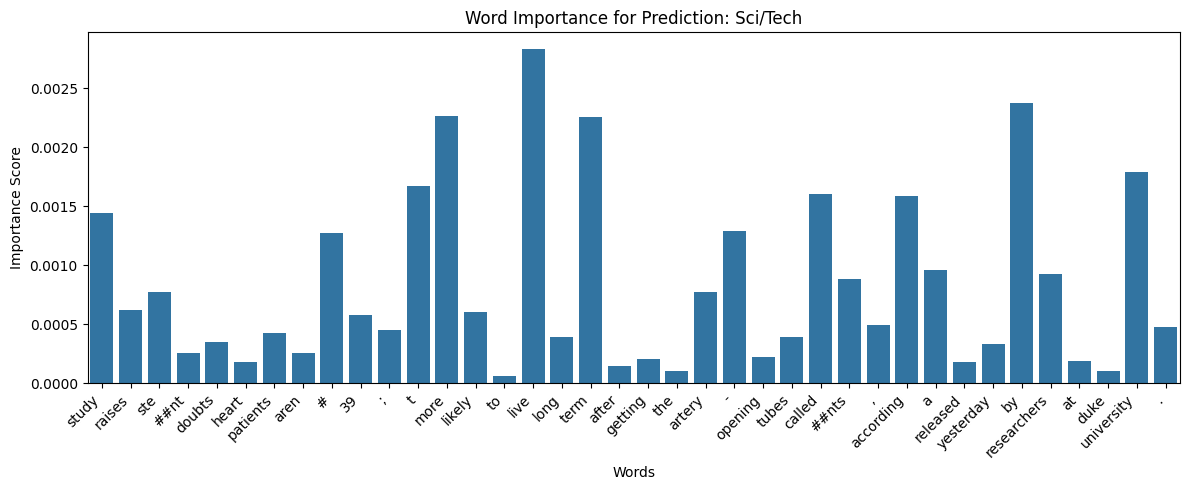

In [153]:
# Explain a specific index
is_misclassified, explanations, word_importances = explainer.explain(index=7)


Index: 72
Text: Tiger Telematics Plans Business Smartphone Tiger Telematics acquired Integra SP, a UK company that produces software allowing real-time streaming of data and applications to handheld devices.

Detailed Predictions:
Sci/Tech: 94.96%
Business: 2.28%
World: 1.64%
Sports: 1.12%

Predicted: Sci/Tech
Confidence: 94.96%
Status: MISCLASSIFIED


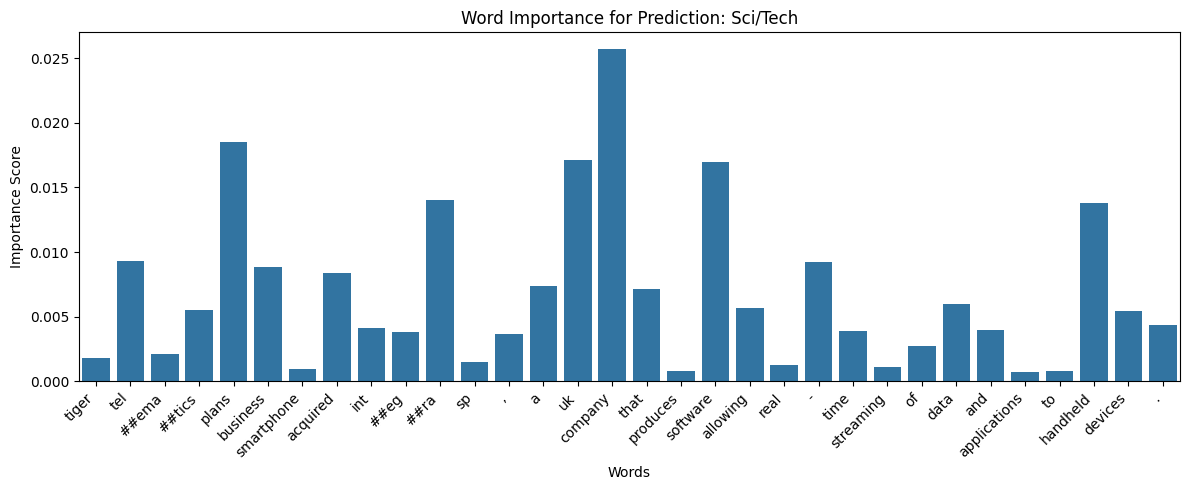

In [154]:
# Explain a specific index
is_misclassified, explanations, word_importances = explainer.explain(index=72)

# Model Performance Summary:

The BERT model shows overall solid performance, achieving an accuracy of 79%. It performs particularly well in the Sports category, with a precision and recall of 87%, leading to an F1-Score of 87%. The World category also sees strong results, with a precision of 78% and recall of 81%, indicating balanced performance. However, Business articles are more challenging for the model, with the lowest precision (73%) and a relatively lower recall (76%), suggesting room for improvement. Sci/Tech has a decent precision of 78% but a slightly lower recall of 72%, pointing to some difficulty in correctly identifying these articles. 

The confusion matrix reveals several misclassifications, with World articles sometimes being labeled as Business or Sci/Tech, and Business articles often misclassified as Sci/Tech. Specifically, indices 7, 15, and 72 were misclassified by the model. However, upon running the model again, index 7 was correctly classified. Index 15 was misclassified as both Sci/Tech and Business during different runs of the model. In the case of index 72, it was misclassified as Sci/Tech, likely due to the presence of keywords such as "software," "smartphone," and "applications," which are more closely associated with the Sci/Tech category. Despite these occasional errors, the model shows strong performance, particularly in the Sci/Tech category, where it frequently makes high-confidence predictions exceeding 90%. However, the misclassifications, such as predicting Sci/Tech for World (index 15) and Business (index 72), suggest the model may struggle to distinguish between categories with similar content. The model would probably do better if more context were available.